# Load libraries and dataset

---



In [1]:
import pandas as pd
import numpy as np
from fancyimpute import KNN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
import random
import os


Using TensorFlow backend.
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24

In [ ]:
# load data set
santander_train = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0106/train.csv")
santander_test = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/edwisor-india-bucket/projects/data/DataN0106/test.csv")

# Exploratory data analysis

---



In [3]:
# view random 5 records from train dataset
print(santander_train.info())
santander_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
12793,train_12793,0,11.5231,-4.1142,8.9041,7.9673,9.1994,-4.3594,4.9353,17.9553,5.2974,9.4048,4.0960,3.0131,14.2508,3.9203,6.1171,14.9105,7.4858,-12.9769,11.3266,10.7796,23.3330,24.4848,10.2384,2.5270,17.3691,13.5750,-5.5262,0.2169,5.4486,5.1342,-7.4626,6.9368,5.0068,12.1987,11.0077,-2.1147,4.8629,3.9049,...,36.9821,5.4291,3.4522,22.2199,3.8929,24.2061,3.6968,-7.4111,6.3660,6.3331,6.5126,6.6858,44.2684,-0.6184,29.7087,11.4410,-5.5934,9.2745,14.4750,3.4385,-7.5875,7.7344,0.0296,10.7916,14.4028,-5.0280,12.5521,-5.0148,10.9528,0.5914,6.2390,7.3009,1.7001,-0.3232,15.1479,1.1076,10.5755,8.1103,16.4822,7.1308
86977,train_86977,0,9.3502,-5.2260,8.9087,7.0825,10.3904,5.0933,5.0626,14.8981,-1.0860,8.9261,0.5806,-1.8991,13.9378,2.4450,7.0538,14.9336,12.6903,-4.6115,31.6555,6.0877,8.6025,32.4772,5.9646,3.5652,13.4041,13.5076,-1.1548,-2.9628,5.3274,7.8480,2.0478,14.7223,-2.7312,18.8469,11.4825,8.3719,1.9587,2.8051,...,9.4102,5.8237,4.0528,16.7340,1.1341,21.9582,3.1491,-3.5552,7.0148,6.0224,-6.2119,-0.1375,25.2786,4.0248,17.9922,11.6033,-0.9716,11.2912,-19.3117,2.7273,-8.4502,8.8606,10.0995,6.2905,7.3736,-13.4772,3.7523,-26.3449,15.3716,0.6142,-2.8130,10.3078,-0.7583,3.4966,17.7597,-1.8954,-4.7411,9.7509,17.0527,-10.1952
168146,train_168146,0,8.3504,2.7942,8.9959,7.0685,10.9879,-15.3207,3.7470,23.1572,4.1638,7.9257,6.5684,-4.0017,13.9286,13.6031,8.9569,14.7957,9.8745,4.9957,4.0426,8.7808,16.7605,25.3907,5.6399,4.0711,13.8105,13.6195,-6.3953,0.2846,5.7475,7.7115,4.7608,7.8370,0.2248,15.7674,11.4225,-1.9913,8.5382,7.3165,...,29.3695,5.5081,4.7008,10.0895,-5.9514,25.0484,3.0735,-1.4628,8.2910,6.3497,7.1461,3.8189,35.9995,3.2634,19.9173,15.6294,-4.7428,11.7462,-3.0474,8.5339,-3.7975,8.8994,15.1727,4.8209,7.2734,-2.3482,14.2915,-27.1587,15.3770,2.7333,-6.9435,7.1064,1.1833,-0.0326,17.7729,-0.9926,-1.4020,7.5099,19.1033,-18.7199


In [4]:
# view random 5 records from test dataset
print(santander_test.info())
santander_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
166574,test_166574,9.0102,2.4480,8.9363,3.9922,12.1413,-8.2223,5.3348,19.9050,6.0140,7.7204,1.5806,-5.2973,14.2293,12.2716,9.3074,13.9631,11.7443,-4.9750,24.1934,20.2510,14.4708,8.7577,1.4535,2.5945,13.5641,14.0038,-3.5925,-2.4772,4.5891,6.9296,5.9006,10.8885,1.2826,10.4589,10.9070,2.6144,5.9490,4.3303,7.5019,...,22.1168,6.1475,6.2922,14.5472,0.3459,25.6715,3.1931,-6.3250,8.3026,5.8877,-8.0681,-8.0321,5.9480,9.5404,8.1661,12.1390,-12.8653,12.0999,-2.4041,-0.6950,0.5052,9.3227,0.6456,7.2535,19.1177,-7.3680,6.8656,12.7012,13.9041,-0.6077,0.8034,3.1069,3.8540,5.0201,18.3606,0.3408,-0.4728,8.2040,8.2687,-25.6837
112440,test_112440,6.2097,0.3578,14.3644,4.5160,10.7776,-7.1679,4.2781,21.8982,1.2236,6.5642,4.8342,-0.5918,14.0580,4.3756,7.7520,14.7564,6.5128,-6.9524,15.4767,3.3754,14.5239,15.6212,6.0994,2.4689,7.8706,13.3167,-2.6032,-0.1700,5.3355,2.8882,-16.3621,11.4200,3.6752,17.0007,11.6814,10.6560,-3.6462,3.4838,10.2570,...,27.8652,5.3252,5.8525,20.0525,-7.9195,13.5381,2.8667,-7.8260,7.9622,5.8239,-5.8009,-1.9489,20.2811,4.8898,26.5296,15.1548,-7.5657,8.8384,1.7453,7.6128,-9.7210,8.3440,-1.4011,14.9759,14.0702,-6.9078,5.2624,-9.0456,20.1662,2.1764,2.7839,3.5830,1.8818,0.8294,20.3457,-1.2578,-0.9306,10.0340,13.4440,-0.3522
128922,test_128922,13.6096,-4.3276,15.5710,5.7166,11.1538,-11.0994,6.2189,14.1435,-4.9327,8.8480,-3.2879,-6.8102,13.9394,6.5068,5.1768,14.4686,15.8109,-13.8975,2.3401,14.1607,10.0336,24.0249,7.2598,2.9593,15.4708,13.5073,-7.5357,0.8860,6.6958,4.0321,-18.7817,11.3335,-1.7860,10.1747,11.2906,6.6674,2.9326,8.7728,3.4746,...,16.3082,5.4782,8.0092,2.0274,-9.2741,21.4166,2.5729,3.3074,4.5964,5.7173,5.1879,-3.9352,24.4765,3.2960,22.5442,12.1997,3.5690,10.9498,-12.6310,1.0859,-5.5545,10.1588,2.9172,9.4652,-4.2995,1.8575,11.9900,-7.3693,22.3003,0.9841,4.8618,8.5395,3.7955,3.1710,16.8387,0.2647,1.6591,8.5954,12.9289,-20.0932


In [5]:
# view dataframe info
print ("The shape of the train data is (row, column):"+ str(santander_train.shape))
print (santander_train.info())

The shape of the train data is (row, column):(200000, 202)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None


In [6]:
# view column names
santander_train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [0]:
# drop ID_code variable as it can't help in prediction
santander_train = santander_train.drop(columns = ['ID_code'])

In [0]:
# re-order columns - set target to last column
cols = santander_train.columns.tolist()
cols = cols[1:201] + cols[0:1]
santander_train = santander_train[cols]


In [9]:
# dataset info
santander_train.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,0.662956,...,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537,0.100490
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,4.068845,...,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015,0.300653
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,-14.545700,...,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.20

In [0]:
# take backup
santander_train_backup = santander_train
# santanderTrain = santanderTrainBackup

# Missing value analysis

---



In [11]:
# view missing values count against variable
total = santander_train.isnull().sum().sort_values(ascending=False)
percent = (santander_train.isnull().sum()/santander_train.isnull().count()).sort_values(ascending=False)
missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missingData.head()


,Total,Percent
target,0,0.0
var_62,0,0.0
var_72,0,0.0
var_71,0,0.0
var_70,0,0.0


# Outlier Analysis

---



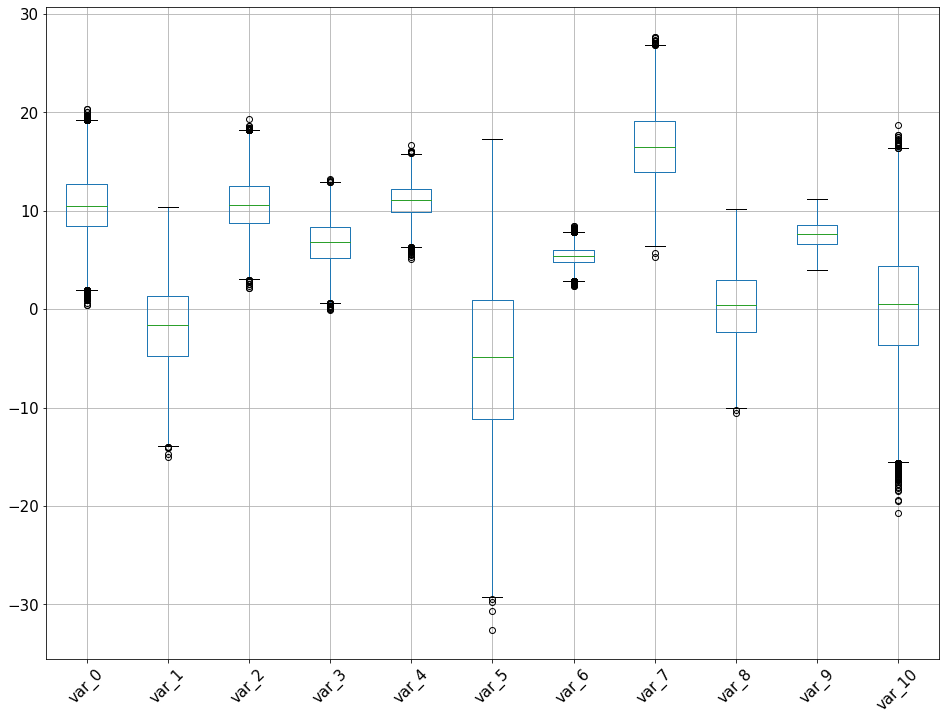

In [12]:
# plot outliers in data frame
plt.figure(figsize=(16, 12))
santander_train.boxplot(column=['var_0', 'var_1', 'var_2','var_3','var_4', 'var_5', 'var_6','var_7','var_8', 'var_9','var_10'] , fontsize = 15, rot = 45)

In [13]:
# Detect and replace with NA
for i in range(0, santander_train.shape[1] - 1):
    column_name = santander_train.columns[i]
    print(column_name)
    q75, q25 = np.percentile(santander_train.iloc[:,i], [75,25])
    iqr = q75 - q25
    lower_fence = round(q25 - (1.5*iqr),4)
    upper_fence = round(q75 + (1.5*iqr),4)
    print('lower_fence :', lower_fence)
    print('upper_fence :', upper_fence)
    # replace outlier with NA
    santander_train.loc[santander_train.iloc[:,i] < lower_fence, column_name] = np.nan
    santander_train.loc[santander_train.iloc[:,i] < lower_fence, column_name] = np.nan


var_0
lower_fence : 1.9973
upper_fence : 19.2147
var_1
lower_fence : -13.888
upper_fence : 10.5066
var_2
lower_fence : 3.0311
upper_fence : 18.208
var_3
lower_fence : 0.649
upper_fence : 12.9291
var_4
lower_fence : 6.3162
upper_fence : 15.8281
var_5
lower_fence : -29.3881
upper_fence : 19.1125
var_6
lower_fence : 2.9148
upper_fence : 7.8559
var_7
lower_fence : 6.2051
upper_fence : 26.8416
var_8
lower_fence : -10.2014
upper_fence : 10.8214
var_9
lower_fence : 3.6704
upper_fence : 11.5329
var_10
lower_fence : -15.5618
upper_fence : 16.3497
var_11
lower_fence : -20.0557
upper_fence : 13.398
var_12
lower_fence : 13.4887
upper_fence : 14.5695
var_13
lower_fence : -5.7302
upper_fence : 23.0777
var_14
lower_fence : 0.5491
upper_fence : 14.5032
var_15
lower_fence : 13.3453
upper_fence : 15.792
var_16
lower_fence : 2.0468
upper_fence : 16.4613
var_17
lower_fence : -24.9744
upper_fence : 13.6874
var_18
lower_fence : -8.5751
upper_fence : 38.7664
var_19
lower_fence : -11.9588
upper_fence : 36.668

,Total,Percent
var_44,1012,0.005060
var_93,793,0.003965
var_146,582,0.002910
var_124,361,0.001805
var_193,344,0.001720


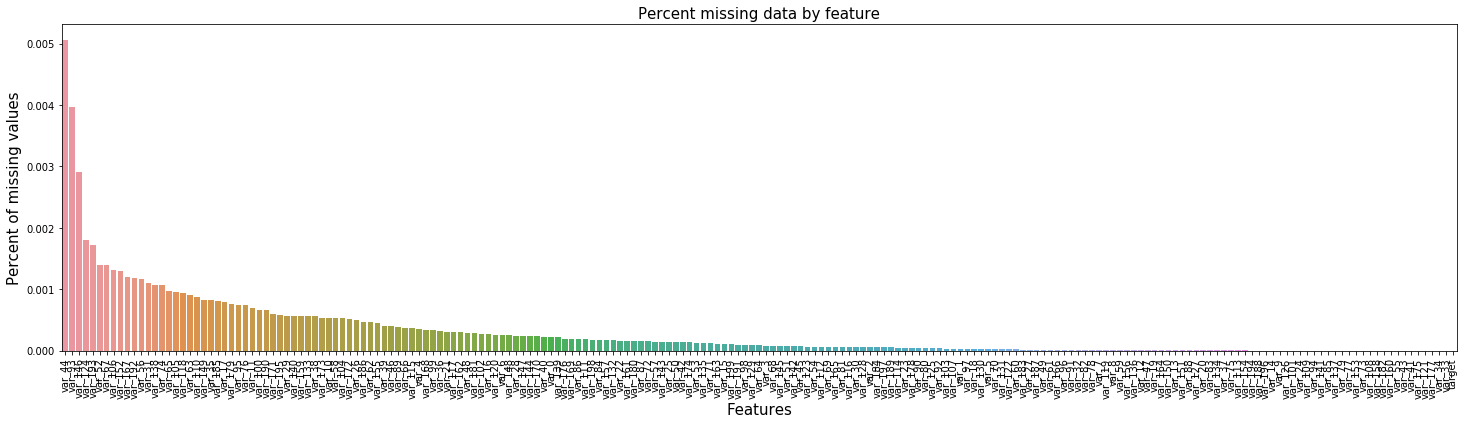

In [14]:
# Now, we have missing values
# view missing values count against variable
total = santander_train.isnull().sum().sort_values(ascending=False)
percent = (santander_train.isnull().sum()/santander_train.isnull().count()).sort_values(ascending=False)
missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# bar plot of missing value data
f, ax = plt.subplots(figsize=(25, 6))
plt.xticks(rotation='90')
sns.barplot(x=missingData.index, y = missingData['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missingData.head()

In [0]:
# impute with mean method
santander_train.fillna(santander_train.mean(), inplace=True)

In [16]:
# verify missing values are filled by mean method
santander_train.isnull().sum().sort_values(ascending=False)

target     0
var_62     0
var_72     0
var_71     0
var_70     0
          ..
var_130    0
var_129    0
var_128    0
var_127    0
var_0      0
Length: 201, dtype: int64

# Feature selection

In [17]:
# Training set high correlations
df_train_corr = santander_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)

df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient


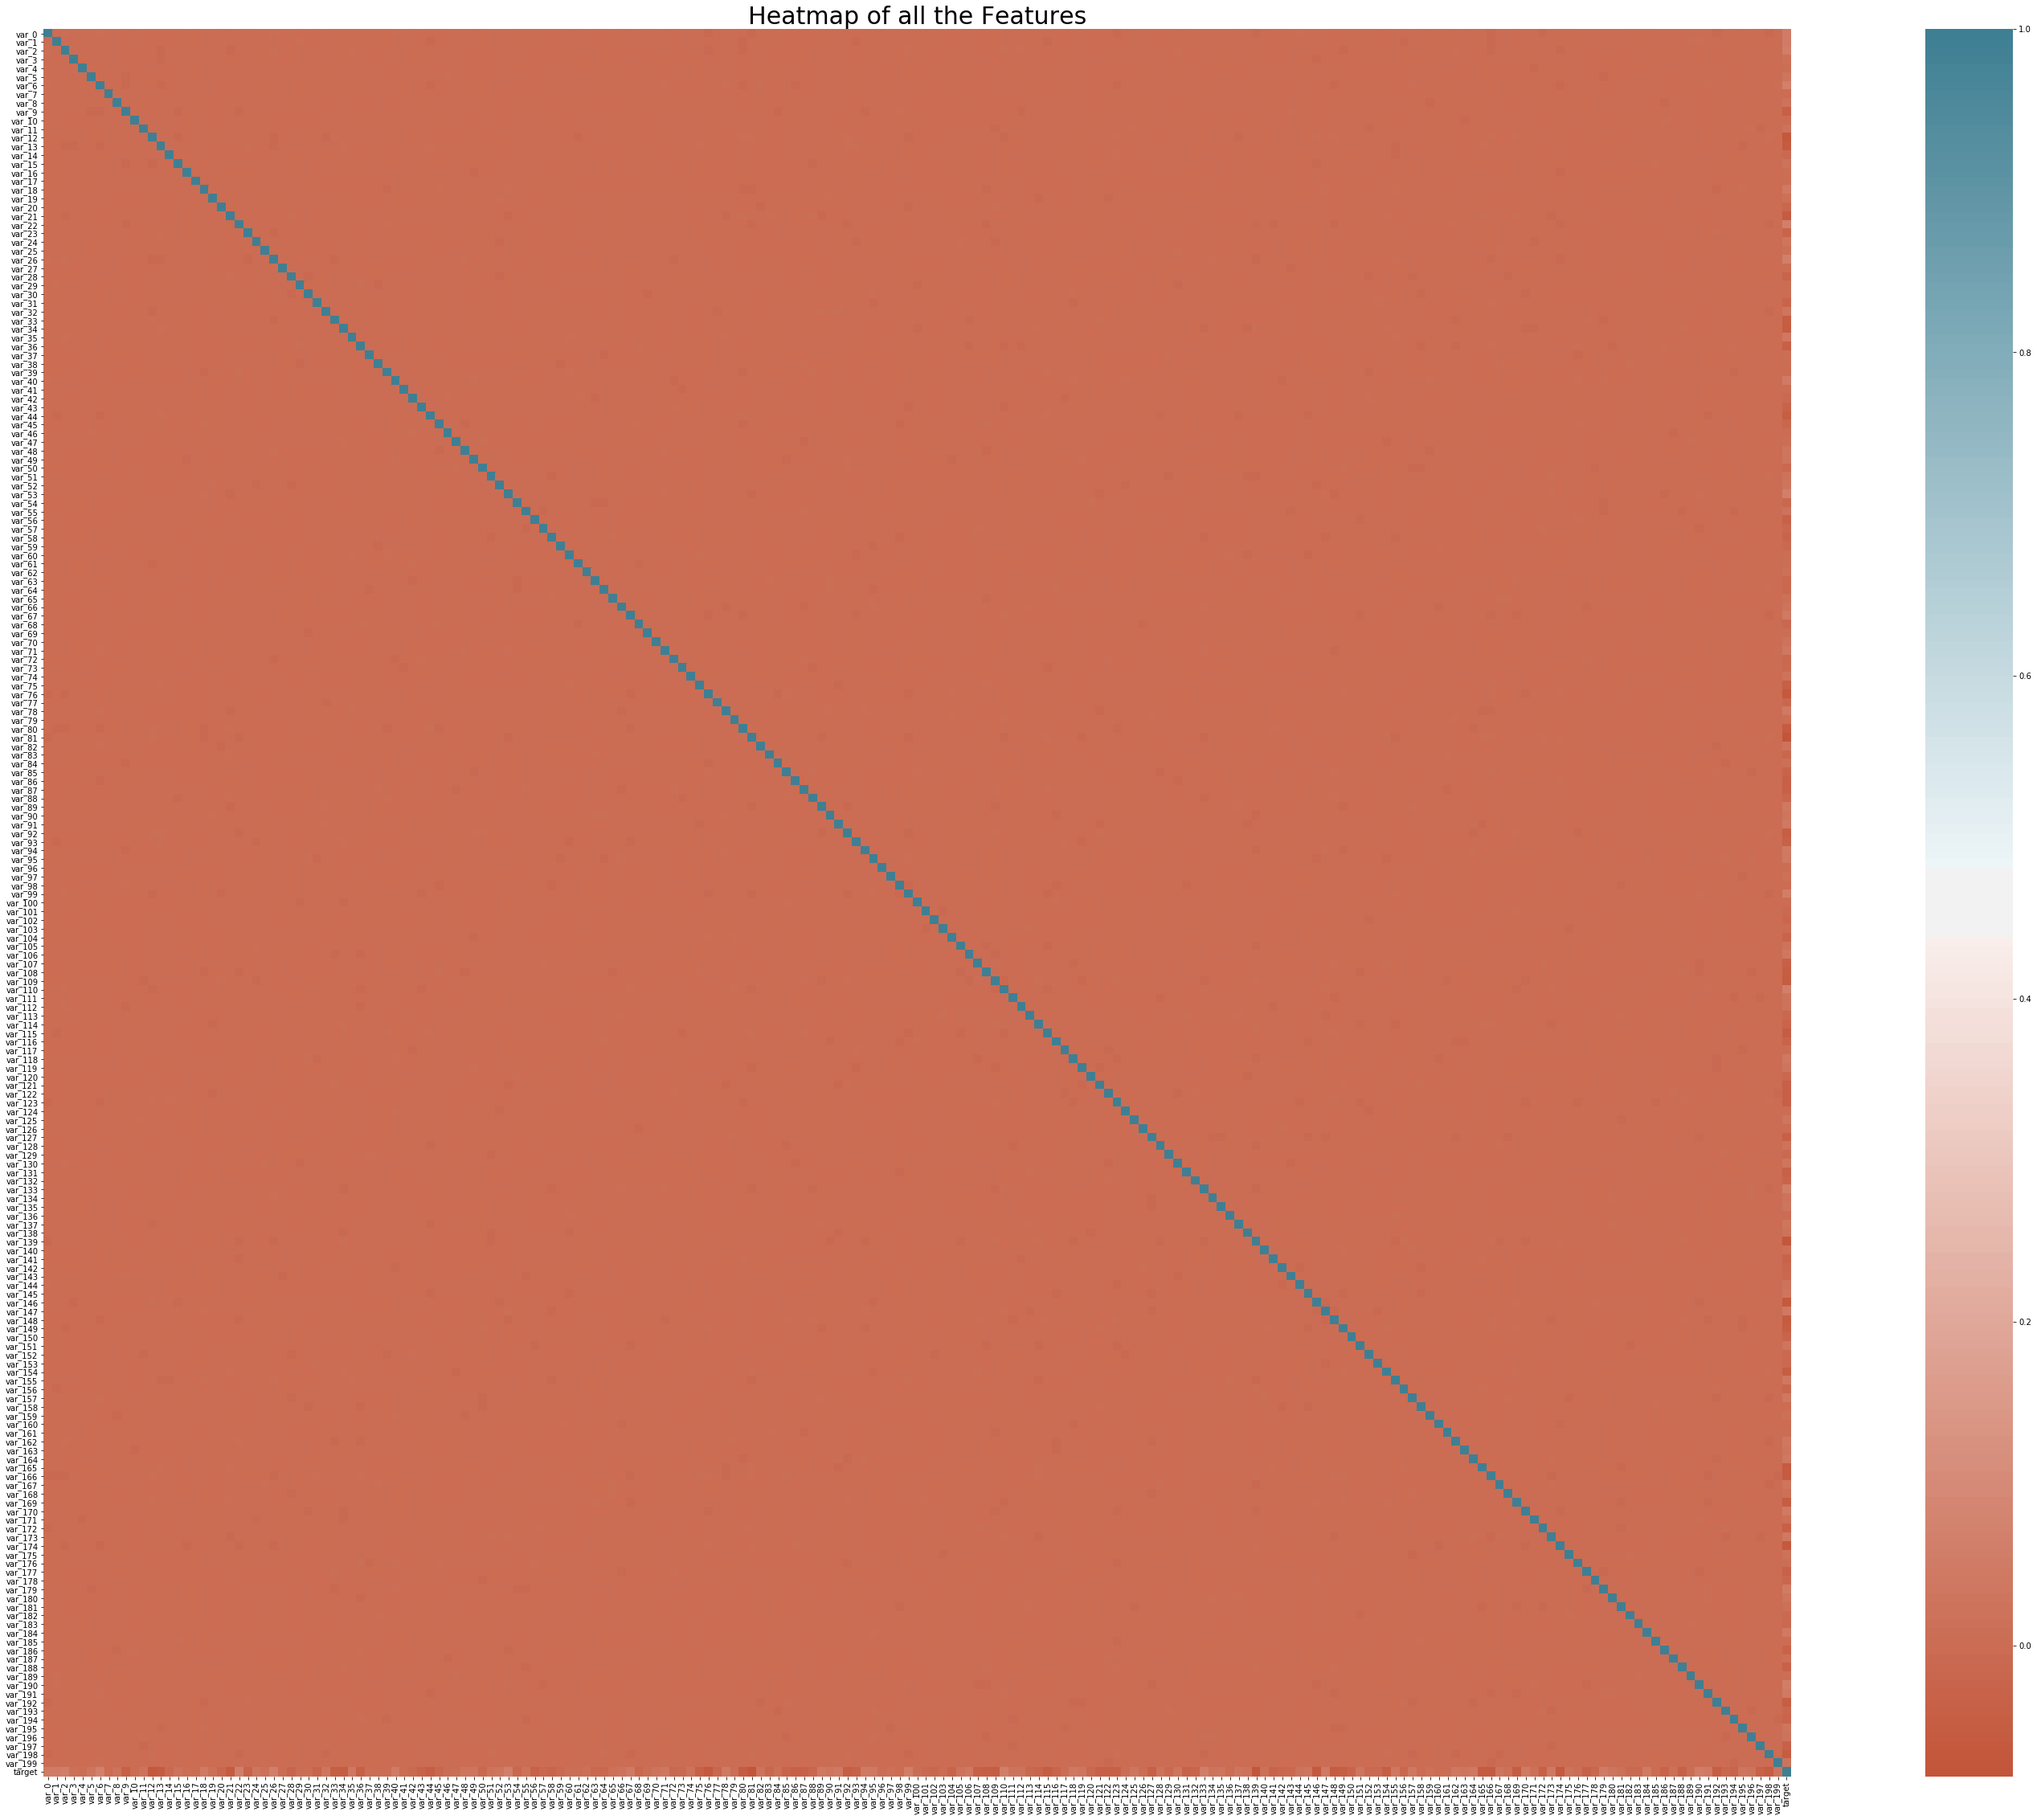

In [18]:
# plot heatmap 
# Set width and height of plot
f,ax = plt.subplots(figsize=(60,40))

# Generate correlation matrix
corr = santander_train.corr()

# plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr,dtype=np.bool), cmap=sns.diverging_palette(20, 220, n=200) ,square=True, ax=ax)
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

# Handle imbalance data

---



Class 0: 179902
Class 1: 20098


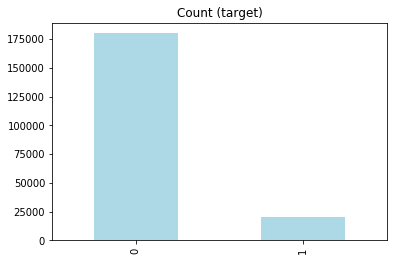

In [19]:
target_count = santander_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])

target_count.plot(kind='bar', title='Count (target)', color = "lightblue");

In [0]:
# spit data into dependent and independent variable
X = santander_train.values[:,0:200]
Y = santander_train.values[:,200]

In [0]:
# split data into four parts, train and test with dependent and independent
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1, stratify=Y)

In [40]:
print('Number of Training Examples = {}'.format(X_train.shape))
print('Number of Test Examples = {}\n'.format(X_test.shape))
print('Training target Shape = {}'.format(y_train.shape))
print('Training target Shape = {}\n'.format(y_test.shape))

Number of Training Examples = (160000, 200)
Number of Test Examples = (40000, 200)

Training target Shape = (160000,)
Training target Shape = (40000,)



In [41]:
# use SMOTE technique to balance dataset
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

# view shape of dataset
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((287844, 200), (287844,), (40000, 200), (40000,))

Class 0: 143922
Class 1: 143922


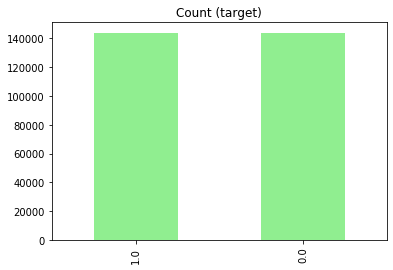

In [42]:
# verify balanced traget into train data
target_count = pd.DataFrame(y_train)[0].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
target_count.plot(kind='bar', title='Count (target)', color = "lightgreen");



---



# Feature scaling

In [0]:
# Normalization function
def normalize_data(df) :
  for i in range(0, df.shape[1]) :
    df.iloc[:,i] = (df.iloc[:,i] - (df.iloc[:,i].min()))/((df.iloc[:,i].max()) - (df.iloc[:,i].min()))

In [0]:
# Normalization
df_x_train = pd.DataFrame(X_train)
df_x_test = pd.DataFrame(X_test)
normalize_data(df_x_train)
normalize_data(df_x_test)

In [53]:
# view normalize data
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
count,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,...,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000,287844.000000
mean,0.485465,0.515670,0.482746,0.491907,0.462116,0.524982,0.465189,0.471270,0.514436,0.491755,0.465122,0.455891,0.445035,0.477276,0.466776,0.491492,0.458583,0.438011,0.481245,0.519768,0.476770,0.407959,0.457356,0.447783,0.470976,0.457612,0.470586,0.509180,0.407965,0.476717,0.507123,0.377221,0.525779,0.464215,0.454800,0.478961,0.417121,0.531762,0.385745,0.440230,...,0.479532,0.486948,0.468577,0.486916,0.531467,0.419835,0.441034,0.476739,0.478006,0.411790,0.441987,0.454525,0.411623,0.478521,0.460828,0.481407,0.491494,0.435521,0.445477,0.421647,0.505082,0.477676,0.482686,0.468770,0.477854,0.443315,0.421621,0.519900,0.432251,0.472233,0.472796,0.497110,0.404007,0.424268,0.486998,0.483526,0.517570,0.459586,0.439340,0.507936
std,0.157531,0.157844,0.154387,0.151426,0.145369,0.160147,0.148701,0.150009,0.153458,0.161947,0.148992,0.149136,0.157704,0.162644,0.149473,0.151742,0.149508,0.141515,0.148356,0.161897,0.157811,0.142748,0.146264,0.144527,0.145404,0.146842,0.156773,0.158245,0.137029,0.156306,0.157303,0.125713,0.161184,0.144750,0.146655,0.154604,0.139286,0.163893,0.126689,0.143368,...,0.156462,0.153110,0.149560,0.155969,0.163722,0.141810,0.152527,0.156395,0.158193,0.138297,0.141982,0.147251,0.141451,0.151661,0.154375,0.153731,0.155094,0.156952,0.144674,0.144191,0.160279,0.155116,0.151788,0.147344,0.150092,0.142536,0.141473,0.160337,0.149456,0.145212,0.153844,0.158367,0.136184,0.140613,0.154628,0.157879,0.161998,0.150623,0.154512,0.154703
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.371023,0.399286,0.367814,0.381451,0.358331,0.404002,0.357188,0.359934,0.399855,0.372347,0.359632,0.351227,0.337775,0.358626,0.353631,0.381535,0.350646,0.338301,0.371301,0.399063,0.355169,0.308449,0.351297,0.344450,0.360986,0.352352,0.358407,0.392288,0.314540,0.367406,0.390265,0.289145,0.407161,0.356793,0.348669,0.369926,0.320513,0.409549,0.296738,0.341325,...,0.357886,0.376338,0.362199,0.371582,0.4113

In [54]:
print('Number of Training Examples = {}'.format(X_train.shape))
print('Number of Test Examples = {}\n'.format(X_test.shape))
print('Training target Shape = {}'.format(y_train.shape))
print('Training target Shape = {}\n'.format(y_test.shape))

Number of Training Examples = (287844, 200)
Number of Test Examples = (40000, 200)

Training target Shape = (287844,)
Training target Shape = (40000,)



# Sampling

---



In [0]:
# simple random sampling
santanderSample = santanderTrain.sample(50000)

In [0]:
santanderSample.head()



---

# **Model** **Development**


---



In [0]:
# function for plot ROC 
def plot_roc(model) :
  # calculate the fpr and tpr for all thresholds of the classification
  probs = model.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  # plot ROC
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


# **Logistic Regression**

In [56]:
# build logistic regression
logistic_regresssion_model = LogisticRegression()
logistic_regresssion_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# predict logistic regression model
logit_predict = logistic_regresssion_model.predict(X_test)

In [58]:
# build confusion matrix
confusion_matrix_logit = pd.crosstab(y_test, logit_predict, rownames=['Actual'], colnames=['Predicted'])

# Let us save TN, TP, FN, FP
TP = confusion_matrix_logit.iloc[0,0]
FN = confusion_matrix_logit.iloc[0,1]
FP = confusion_matrix_logit.iloc[1,0]
TN = confusion_matrix_logit.iloc[1,1]

# check Accuracy
(TP + TN) * 100 / (TP+TN+FP+FN) 

# FNR
# (FN*100)/(TP+FN)

78.9325

In [68]:
1 - 0.7893

0.2107

In [65]:
(TP*100)/(TP+FN)

79.34130072262369

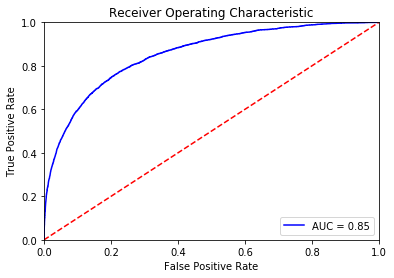

In [61]:
plot_roc(logisticRegresssionModel)

**Logistic Regression perforamce matrix**



```
* all records
```



*   Accuracy - 78.57 / 78.93*
*   Misclassification - 21.43 / 21.07*
*   Recall - 78.69 / 79.34*
*   Precision - 96.91 / 96.63*
*   FNR - 21.30 / 20.65*
*   AUC - 0.86 / 0.85*








# **Random forest**

In [0]:
# Random Forest
random_forest_model = RandomForestClassifier(n_estimators = 150).fit(X_train, y_train)

In [70]:
random_forest_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_prediction = random_forest_model.predict(X_test)

In [73]:
# build confusion matrix
confusion_matrix_random_forest = pd.crosstab(y_test, random_forest_prediction,  rownames=['Actual'], colnames=['Predicted'])

# Let us save TN, TP, FN, FP
TP = confusion_matrix_random_forest.iloc[0,0]
FN = confusion_matrix_random_forest.iloc[0,1]
FP = confusion_matrix_random_forest.iloc[1,0]
TN = confusion_matrix_random_forest.iloc[1,1]

# check Accuracy
(TP + TN) / (TP+TN+FP+FN) * 100

# FNR
# (FN*100)/(TP+FN)

89.8875

In [79]:
confusion_matrix_random_forest

Predicted,0.0,1.0
Actual,,
0.0,35934,46
1.0,3999,21


In [78]:
(TP*100)/(TP+FP)

89.98572609120276

In [82]:
# plot ROC curv
plot_roc(random_forest_model)

NameError: ignored

No handles with labels found to put in legend.


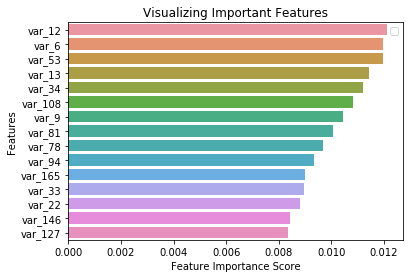

<Figure size 1080x1440 with 0 Axes>

In [89]:
feature_imp = pd.Series(randomForestModel.feature_importances_, index = santander_train.columns.values[0:200]).sort_values(ascending=False)

fimp = feature_imp[0:15]

%matplotlib inline
# Creating a bar plot
sns.barplot(x=fimp, y=fimp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.figure(figsize=(15, 20))
plt.show()

In [0]:
# d2 = feature_imp[feature_imp < 0.004]
# # d2 = feature_imp

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(d2)

In [0]:
# # pd.DataFrame(X_train).head()
# d3 = pd.DataFrame(X_train)

# d3.drop(columns=[0], inplace=True)

# d3.head()

**Random forest perforamce matrix**

`No of Trees - 100 `


```
* no of trees 150 full data
```


*   Accuracy - 89.8 / 89.88*
*   Misclassification - 10.19 / 10.11*
*   Recall - 99.61 / 99.87*
*   Precision - 90.09 / 89.98*
*   FNR - 38.23 / 12.78*
*   AUC - 0.70 /0.73*




# **Naive bayes classifier**




In [0]:
# Naive bayes implementation
naive_bayes_model = GaussianNB().fit(X_train,y_train)

In [0]:
# predict naive bayes
naive_bayes_predict = naive_bayes_model.predict(X_test)

In [123]:
# build confusion matrix
confusion_matrix_naive_bayes = pd.crosstab(y_test, naive_bayes_predict, rownames=['Actual'], colnames=['Predicted'])

# Let us save TN, TP, FN, FP
TP = confusion_matrix_naive_bayes.iloc[0,0]
FN = confusion_matrix_naive_bayes.iloc[0,1]
FP = confusion_matrix_naive_bayes.iloc[1,0]
TN = confusion_matrix_naive_bayes.iloc[1,1]

# check Accuracy
((TP + TN) / (TP+TN+FP+FN)) * 100 

# FNR
# (FN*100)/(TP+FN)

89.4225

In [106]:
# view confusion matrix
confusion_matrix_naive_bayes

Predicted,0.0,1.0
Actual,,
0.0,35719,261
1.0,3970,50


In [126]:
(TP*100)/(TP+FP)

89.99722845120814

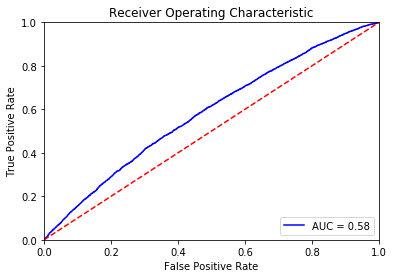

In [127]:
# plot ROC curv
plot_roc(naiveBayesModel)

**Random forest perforamce matrix**


*   Accuracy - 87.03 / 89.42*
*   Misclassification - 12.96 / 10.57*
*   Recall - 95.71 / 99.27*
*   Precision - 90.43 / 89.99*
*   FNR - 4.28 / 72.54*
*   AUC - 0.61 /0.58*





# **KNN Classifier**

In [0]:
# model development
knn_model = KNeighborsClassifier(n_neighbors= 3).fit(X_train,y_train)

In [0]:
# predict test cases
knn_predict = KNNModel.predict(X_test)

In [0]:
# build confusion matrix
confusion_matrix_knn = pd.crosstab(y_test, knn_predict,  rownames=['Actual'], colnames=['Predicted'])

# Let us save TN, TP, FN, FP
TP = confusion_matrix_knn.iloc[0,0]
FN = confusion_matrix_knn.iloc[0,1]
FP = confusion_matrix_knn.iloc[1,0]
TN = confusion_matrix_knn.iloc[1,1]

# check Accuracy
# (TP + TN) / (TP+TN+FP+FN) * 100

# FNR
(FN*100)/(TP+FN)

In [0]:
confusion_matrix_knn

**KNN perforamce matrix**


*   Accuracy - 
*   Misclassification - 
*   Recall - 
*   Precision - 
*   FNR - 